                        Projet n°5 Catégorisez automatiquement des questions
Nous allons dans cette étude proposez une analyse textuelle des questions posées sur le site Stackoverflow. 
Notre objectif final est de suggérer des tags relatifs à la question posée afin d'aider les débutants dans leurs premiers pas sur le site.

Ce notebook représente le test des différents modèles
- <a href="#C1">1. Importation des données
- <a href="#C2">2. Approche non supervisée
    - <a href="#C2.1">2.1 Latent Dirichlet Allocation      
    - <a href="#C2.1.1">2.1.1 Modèle de base 
    - <a href="#C2.1.2">2.1.2 Optimisation du modèle
    - <a href="#C2.1.3">2.1.3 Représentation graphique
- <a href="#C3">3. Approche supervisée
    - <a href="#C3.1">3.1 Approche BOW, TFIDF      
        - <a href="#C3.1.1">3.1.1 Entrainement des modèles      
        - <a href="#C3.1.2">3.1.2 Syntèse des résultats
        - <a href="#C3.1.3">3.1.3 Optimisation des hyperparamètres
        - <a href="#C3.1.4">3.1.4 Représentation graphique
    - <a href="#C3.2">3.2 Approche avec Word2Vec     
    - <a href="#C3.3">3.3 Approche avec Doc2Vec
    - <a href="#C3.4">3.4 Approche avec Glove
    - <a href="#C3.5">3.5 Approche avec BERT
    - <a href="#C3.6">3.6 Approche avec USE
 

In [12]:
# Bult-in
import os, sys, time, random

# Data
import numpy as np
import pandas as pd
from ast import literal_eval

# Visualizationraw_corpus
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
#from PIL import Image

import re

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn import cluster, metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from sklearn.metrics import confusion_matrix, classification_report, hamming_loss


from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC , SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

#from skmultilearn.problem_transform import BinaryRelevance
from sklearn.tree import DecisionTreeClassifier

from sklearn.manifold import TSNE

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import words

from pandarallel import pandarallel

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
sns.set()

/Applications/Anaconda/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Applications/Anaconda/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


# <a name="C1">1. Importation des données</a>

In [13]:
df = pd.read_csv("data/cleaned/df_final_version.csv",sep=';')

In [14]:
#df.Title = df['title_bow'].apply(lambda x : word_tokenize(x))
#df.Body = df['body_bow'].apply(lambda x : word_tokenize(x))
#df.Tags = df['tag_bow'].apply(lambda x : word_tokenize(x))

In [15]:
for col in ['Title', 'Body', 'Tags']:
     df[col] = df[col].apply(literal_eval)

In [16]:
df

,Title,Body,Tags
0,"[selenium, button, webdriver, find]","[loosing, page, left, focus, href, working, cl...","[html, webdriver, selenium, python]"
1,"[policy, rest, access, nifi, api, using]","[policy, following, set, rest, instance, get, ...","[apache, rest, python]"
2,"[based, table, existence, subtable, row]","[fruit, table, select, enabled, seeing, fruits...","[mysql, sql]"
3,"[route, uris, go, localizing]","[register, go, multiple, route, french, versio...",[laravel]
4,"[service, public, app, access, restriction, az...","[image, networking, src, explorer, checked, fa...",[azure]
...,...,...,...
78446,"[phone, device, near, bluetooth, detect, scann...","[part, enabled, even, alright, video, message,...","[java, android]"
78447,"[missing_enum_constant_in_switch, make, dart, ...","[github, image, severity, src, complete, langu...","[flutter, dart]"
78448,"[default, cplex, option]","[something, faster, native, ol, problem, linea...",[python]
78449,"[term, many, efficiently, filter]","[elsewhere, command, expect, something, questi...","[r, data, dataframe]"


# <a name="C2">2. Approche non supervisée</a>

In [6]:
# Training models function
def train_clf(nom, modele, df_res, X, y):
    ''' Train models and store the results '''
    
    # Create train and test split (30%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    deb_fit = time.time()
    clf = modele.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    i = len(df_res)
    df_res.loc[i,"Nom"] = nom
    df_res.loc[i,"Modele"] = modele 
    df_res.loc[i,"Durée"] = round(time.time() - deb_fit,2)
    df_res.loc[i,"Accuracy"] = round(accuracy_score(y_test, y_pred),2)
    df_res.loc[i,"Precision"] = round(precision_score(y_test, y_pred, average='samples'),2)
    df_res.loc[i,"Recall"] = round(recall_score(y_test, y_pred, average='samples'),2)
    df_res.loc[i,"F1_score"] = round(f1_score(y_test, y_pred, average='samples'),2)
    df_res.loc[i,"Jaccard spl"] = round(jaccard_score(y_test, y_pred, average='samples'),2)
#    df_res.loc[i,"HammingLoss"] = round(hamming_loss(y_test, y_pred),2)
#    df_res.loc[i,"Jac macro"] = round(jaccard_score(y_test, y_pred, average='macro'),2)
#    df_res.loc[i,"Jac micro"] = round(jaccard_score(y_test, y_pred, average='micro'),2)
#    df_res.loc[i,"Jac wght"] = round(jaccard_score(y_test, y_pred, average='weighted'),2)

#    y_pred_inversed = mlb.inverse_transform(y_pred)
#    y_test_inversed = mlb.inverse_transform(y_test)
#    print("Predicted: ", y_pred_inversed[0:5]
#    print("True     : ", y_test_inversed[0:5])
    return df_res

In [17]:
# Initialization
#dfc = df.sample(frac = .1)
X = df["Body"]
y = df["Tags"]

# Initialize the "CountVectorizer" TFIDF for the Body
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df= 0.90,
                             min_df= 0.0001,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)
vectorizer.fit(X)
X_tfidf = vectorizer.transform(X)

print(X_tfidf.shape)

# Multilabel binarizer for targets
mlb = MultiLabelBinarizer()
y_mlb = mlb.fit_transform(y)

print(y_mlb.shape)

(78451, 13420)
(78451, 100)


In [18]:
import pickle
file_vect = './models/vect.pkl'
pickle.dump(vectorizer, open(file_vect, 'wb'))

In [76]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# Init the DataFrame to store the results
df_res = pd.DataFrame(columns = ["Nom", 
                                 "Modele",
                                 "Durée",
                                 "Accuracy",
                                 "Precision",
                                 "Recall",
                                 "F1_score",
                                 "Jaccard spl"])
#                                 "HammingLoss"])

## <a name="C2.1">2.1 Latent Dirichlet Allocation</a>

### <a name="C2.1.1">2.1.1 Modèle de base</a>

In [83]:
# The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them :
# Dictionary
id2word = corpora.Dictionary(df.Body)
# Corpus
Texts = df.Body
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in Texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [84]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [85]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())

[(0,
  '0.056*"stack" + 0.052*"imgur" + 0.052*"href" + 0.051*"rel" + '
  '0.051*"noreferrer" + 0.051*"nofollow" + 0.049*"png" + 0.039*"src" + '
  '0.039*"img" + 0.038*"image"'),
 (1,
  '0.013*"class" + 0.010*"java" + 0.009*"c" + 0.009*"using" + 0.008*"method" + '
  '0.008*"application" + 0.007*"get" + 0.007*"project" + 0.006*"file" + '
  '0.006*"call"'),
 (2,
  '0.009*"run" + 0.009*"wa" + 0.009*"tried" + 0.008*"running" + 0.008*"using" '
  '+ 0.007*"server" + 0.007*"question" + 0.007*"ha" + 0.006*"doe" + '
  '0.006*"time"'),
 (3,
  '0.040*"class" + 0.038*"pre" + 0.037*"override" + 0.036*"lang" + '
  '0.036*"prettyprint" + 0.020*"lt" + 0.016*"div" + 0.015*"true" + '
  '0.013*"false" + 0.013*"j"'),
 (4,
  '0.017*"animation" + 0.016*"weight" + 0.013*"obtain" + 0.013*"letter" + '
  '0.013*"faster" + 0.011*"middle" + 0.011*"scrolling" + 0.010*"keeping" + '
  '0.010*"quote" + 0.009*"abc"'),
 (5,
  '0.013*"using" + 0.012*"app" + 0.011*"page" + 0.011*"user" + 0.011*"get" + '
  '0.010*"tried" +

In [86]:
#Print Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=Texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', round(coherence_lda,2))


Coherence Score:  0.5


### <a name="C2.1.2">2.1.2 Optimisation du modèle</a>

In [14]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=Texts,
                                         dictionary=id2word, 
                                         coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
topics_range = range(2, 20, 2)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
    pbar.close()

In [12]:
dfr = pd.read_csv('./results/lda_tuning_results.csv')
dfr.sort_values(by=['Coherence'], ascending=False)

,Validation_Set,Topics,Alpha,Beta,Coherence
443,100% Corpus,12,symmetric,0.9099999999999999,0.687015
268,75% Corpus,18,asymmetric,0.9099999999999999,0.680977
193,75% Corpus,14,0.61,0.9099999999999999,0.672524
253,75% Corpus,18,0.61,0.9099999999999999,0.665856
173,75% Corpus,12,symmetric,0.9099999999999999,0.656286
...,...,...,...,...,...
257,75% Corpus,18,0.9099999999999999,0.61,0.390380
227,75% Corpus,16,0.9099999999999999,0.61,0.388107
183,75% Corpus,14,0.01,0.9099999999999999,0.384454
258,75% Corpus,18,0.9099999999999999,0.9099999999999999,0.378519


In [87]:
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=12, random_state=100,
                                passes=10, alpha='symmetric', eta=0.91, chunksize=100)

### <a name="C2.1.3">2.1.3 Représentation graphique</a>

In [62]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
num_topics=12

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.365150  0.029683       1        1  43.642395
6      0.353821 -0.040776       2        1  38.883369
3      0.081468 -0.082545       3        1   8.800009
2     -0.014762  0.233527       4        1   6.228322
4     -0.100250 -0.024791       5        1   0.500782
1     -0.099239 -0.019325       6        1   0.345920
11    -0.097531 -0.015818       7        1   0.297094
8     -0.098040 -0.016637       8        1   0.286807
0     -0.097715 -0.015993       9        1   0.283527
7     -0.097727 -0.016118      10        1   0.251559
10    -0.097646 -0.015853      11        1   0.251409
5     -0.097528 -0.015355      12        1   0.228806, topic_info=                       Term          Freq         Total Category  logprob  \
23               noreferrer  16746.000000  16746.000000  Default  30.0000   
22                 nofollow  16718.000000  16718.000000  Default  29.0000   
30                      rel  16914.000000  16914.000000  Default  28.0000   
13                     href  18782.000000  18782.000000  Default  27.0000   
148                   stack  10012.000000  10012.000000  Default  26.0000   
...                     ...           ...           ...      ...      ...   
75754          name_lang_ka      0.412695      4.992586  Topic12  -9.8168   
75755          name_lang_ru      0.412695      4.992586  Topic12  -9.8168   
75753          name_lang_en      0.411983      5.055033  Topic12  -9.8186   
71869  additionalproperties      0.381123      4.086689  Topic12  -9.8964   
64923       keydeserializer      0.376291      5.890654  Topic12  -9.9092   

       loglift  
23     30.0000  
22     29.0000  
30     28.0000  
13     27.0000  
148    26.0000  
...        ...  
75754   3.5870  
75755   3.5870  
75753   3.5729  
71869   3.7077  
64923   3.3293  

[658 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
17693      1  0.034278     __str__
17693      2  0.205670     __str__
17693      3  0.685567     __str__
17693      4  0.034278     __str__
17693     10  0.034278     __str__
...      ...       ...         ...
12580      1  0.214569  zygoteinit
12580      2  0.214569  zygoteinit
12580      3  0.214569  zygoteinit
12580      4  0.214569  zygoteinit
12580      8  0.214569  zygoteinit

[2725 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 4, 3, 5, 2, 12, 9, 1, 8, 11, 6])

In [88]:
# Obtain topic distributions for each document
topic_dist = pd.DataFrame(lda_model.get_document_topics(corpus, minimum_probability=0.0))
for topic in topic_dist.columns:
    topic_dist[topic] = topic_dist[topic].apply(lambda x : x[1])

print('matrix of document/topic distribution shape:', topic_dist.shape)

matrix of document/topic distribution shape: (78451, 12)


In [89]:
topic_dist.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.154595,0.002042,0.002042,0.002042,0.002042,0.002042,0.002042,0.002042,0.002042,0.002042,0.002042,0.824982
1,0.005561,0.521066,0.005561,0.005561,0.005561,0.005561,0.005561,0.005561,0.005561,0.005561,0.005561,0.423322
2,0.001645,0.001645,0.001645,0.001645,0.001645,0.001645,0.001645,0.001645,0.001645,0.001645,0.140935,0.842618
3,0.005041,0.546778,0.005041,0.005041,0.005041,0.005041,0.005041,0.005041,0.005041,0.005041,0.005041,0.402813
4,0.327239,0.652894,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987


In [90]:
df_res = train_clf("LDA_LR", OneVsRestClassifier(LinearSVC(dual=False, max_iter=10000)),df_res, topic_dist, y_mlb )
df_res

,Nom,Modele,Durée,Accuracy,Precision,Recall,F1_score,Jaccard spl,HammingLoss
0,LDA_LR,OneVsRestClassifier(estimator=LinearSVC(dual=F...,22.15,0.0,0.01,0.01,0.01,0.01,NaN


# <a name="C3">3. Approche supervisée</a>

## <a name="C3.1">3.1 Approche BOW, TFIDF</a>

### <a name="C3.1.1">3.1.1 Entrainement des modèles</a>

In [6]:
# Initialization
#dfc = df.sample(frac = .1)
X = df["Body"]
y = df["Tags"]

# Initialize the "CountVectorizer" TFIDF for the Body
cvect = CountVectorizer(analyzer="word",
                             max_df=.97,
                             min_df= 3,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)
cvect.fit(X)
X_cv = cvect.transform(X)

print(X_cv.shape)

# Multilabel binarizer for targets
mlb = MultiLabelBinarizer()
y_mlb = mlb.fit_transform(y)

print(y_mlb.shape)

(78451, 26530)
(78451, 100)


In [7]:
df['Body_bow'] = [" ".join(doc) for doc in df.Body]
df

,Title,Body,Tags,Body_bow
0,"[selenium, button, webdriver, find]","[loosing, page, left, focus, href, working, cl...","[html, webdriver, selenium, python]",loosing page left focus href working click nex...
1,"[policy, rest, access, nifi, api, using]","[policy, following, set, rest, instance, get, ...","[apache, rest, python]",policy following set rest instance get access ...
2,"[based, table, existence, subtable, row]","[fruit, table, select, enabled, seeing, fruits...","[mysql, sql]",fruit table select enabled seeing fruits_id tw...
3,"[route, uris, go, localizing]","[register, go, multiple, route, french, versio...",[laravel],register go multiple route french version loca...
4,"[service, public, app, access, restriction, az...","[image, networking, src, explorer, checked, fa...",[azure],image networking src explorer checked false hr...
...,...,...,...,...
78446,"[phone, device, near, bluetooth, detect, scann...","[part, enabled, even, alright, video, message,...","[java, android]",part enabled even alright video message consol...
78447,"[missing_enum_constant_in_switch, make, dart, ...","[github, image, severity, src, complete, langu...","[flutter, dart]",github image severity src complete language hr...
78448,"[default, cplex, option]","[something, faster, native, ol, problem, linea...",[python],something faster native ol problem linear pyom...
78449,"[term, many, efficiently, filter]","[elsewhere, command, expect, something, questi...","[r, data, dataframe]",elsewhere command expect something question am...


In [27]:
print (metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.57      0.66      0.61      2794
           2       0.36      0.42      0.39      1683
           3       0.43      0.45      0.44      1250
           4       0.00      0.00      0.00        32
           5       0.36      0.37      0.37       511
           6       0.27      0.34      0.30       546
           7       0.37      0.40      0.38       891
           8       0.24      0.29      0.26       232
           9       0.24      0.24      0.24       176
          10       0.14      0.12      0.13        88
          11       0.50      0.60      0.54       500
          12       0.20      0.18      0.19       122
          13       0.57      0.60      0.59       626
          14       0.25      0.27      0.26       277
          15       0.36      0.43      0.39       174
          16       0.07      0.05      0.06        61
          17       0.34      0.37      0.35       350
          18       0.24    

In [125]:
# Models training (one by one it's safer)
df_res = train_clf("Dummy", OneVsRestClassifier(DummyClassifier(strategy="most_frequent")),df_res, X_tfidf, y_mlb )

In [126]:
df_res = train_clf("NaiveBayes", OneVsRestClassifier(MultinomialNB()),df_res, X_tfidf, y_mlb )

In [127]:
df_res = train_clf("LogReg", OneVsRestClassifier(LogisticRegression(multi_class="multinomial", solver='saga',n_jobs=-1)),df_res, X_tfidf, y_mlb )

In [29]:
df_res = train_clf("LinearSVC", OneVsRestClassifier(LinearSVC(class_weight="balanced")),df_res, X_tfidf, y_mlb )

,Nom,Modele,Durée,Accuracy,Precision,Recall,F1_score,Jaccard spl,HammingLoss
0,RForest,OneVsRestClassifier(estimator=RandomForestClas...,6265.52,0.14,0.36,0.24,0.28,0.24,0.02
1,Bagging,OneVsRestClassifier(estimator=BaggingClassifie...,17252.47,0.2,0.52,0.45,0.46,0.39,0.02
2,GradBoost,OneVsRestClassifier(estimator=GradientBoosting...,9071.04,0.18,0.48,0.42,0.42,0.36,0.02
3,Dummy,OneVsRestClassifier(estimator=DummyClassifier(...,0.81,0.0,0.0,0.0,0.0,0.0,0.02
4,NaiveBayes,OneVsRestClassifier(estimator=MultinomialNB()),3.62,0.03,0.07,0.05,0.05,0.05,0.02
5,LogReg,OneVsRestClassifier(estimator=LogisticRegressi...,220.26,0.2,0.49,0.38,0.41,0.35,0.02
6,LinearSVC,OneVsRestClassifier(estimator=LinearSVC(class_...,101.03,0.14,0.5,0.66,0.53,0.43,0.02


In [7]:
df_res = train_clf("RForest", OneVsRestClassifier(RandomForestClassifier()),df_res, X_tfidf, y_mlb)

,Nom,Modele,Durée,Accuracy,Precision,Recall,F1_score,Jaccard spl,HammingLoss
0,RForest,OneVsRestClassifier(estimator=RandomForestClas...,6265.52,0.14,0.36,0.24,0.28,0.24,0.02


In [24]:
df_res = train_clf("Bagging", OneVsRestClassifier(BaggingClassifier(DecisionTreeClassifier(), n_jobs=-1)),df_res, X_tfidf, y_mlb )

,Nom,Modele,Durée,Accuracy,Precision,Recall,F1_score,Jaccard spl,HammingLoss
0,RForest,OneVsRestClassifier(estimator=RandomForestClas...,6265.52,0.14,0.36,0.24,0.28,0.24,0.02
1,Bagging,OneVsRestClassifier(estimator=BaggingClassifie...,17252.47,0.2,0.52,0.45,0.46,0.39,0.02


In [25]:
df_res = train_clf("GradBoost", OneVsRestClassifier(GradientBoostingClassifier()),df_res, X_tfidf, y_mlb )

,Nom,Modele,Durée,Accuracy,Precision,Recall,F1_score,Jaccard spl,HammingLoss
0,RForest,OneVsRestClassifier(estimator=RandomForestClas...,6265.52,0.14,0.36,0.24,0.28,0.24,0.02
1,Bagging,OneVsRestClassifier(estimator=BaggingClassifie...,17252.47,0.2,0.52,0.45,0.46,0.39,0.02
2,GradBoost,OneVsRestClassifier(estimator=GradientBoosting...,9071.04,0.18,0.48,0.42,0.42,0.36,0.02


In [ ]:
df_res = train_clf("SVCL", OneVsRestClassifier(SVC(kernel="linear", probability=True)),df_res, X_tfidf, y_mlb )
df_res

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
df_res = train_clf("SVCL", OneVsRestClassifier(KNeighborsClassifier()),df_res, X_tfidf, y_mlb)
df_res

### <a name="C3.1.2">3.1.2 Syntèse des résultats</a>

In [31]:
pd.DataFrame(df_res).to_csv('./results/models_results.csv', index=False)

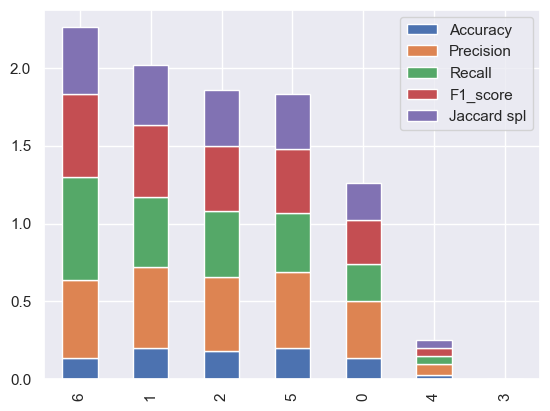

In [75]:
df_res.loc[:,["Accuracy", "Precision", "Recall", "F1_score", "Jaccard spl"]].sort_values(by = 'Jaccard spl', ascending=False).plot(kind='bar', stacked=True)
plt.show()

In [19]:
import pickle
file_X_tfidf = './models/X_tfidf.pkl'
pickle.dump(X_tfidf, open(file_X_tfidf, 'wb'))

file_mlb = './models/mlb.pkl'
pickle.dump(mlb, open(file_mlb, 'wb'))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_mlb, test_size=0.3, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_cv, y_mlb, test_size=0.3, random_state=42)

clf = OneVsRestClassifier(LinearSVC(dual=False, max_iter=10000)).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [21]:
import pickle
file_clf = './models/clf.pkl'
pickle.dump(clf, open(file_clf, 'wb'))

In [22]:
import pickle
# recherche du classifieur pré-entrainé
file_clf = open('./models/clf.pkl', 'rb')
clf = pickle.load(file_clf)
       
# recherche du vectoriseur pré-entrainé
file_vect = open('./models/vect.pkl', 'rb')
vect = pickle.load(file_vect)

In [114]:
text = vect.inverse_transform(X_test[17])
#xx = ""
#xx = 'usestate useeffect two switch sure simple showing show set screen react problem native\
#               matter make main loading information first even empty data call array api always'
#text = []
#text.append(xx)
print (text)
#XX_tfidf = vect.transform(text)
#XX_tfidf


[array(['usestate', 'useeffect', 'two', 'switch', 'sure', 'simple',
       'showing', 'show', 'set', 'screen', 'react', 'problem', 'native',
       'matter', 'make', 'main', 'loading', 'information', 'first',
       'even', 'empty', 'data', 'call', 'array', 'api', 'always'],
      dtype='<U41')]


In [128]:
xx = 'usestate useeffect two switch sure simple showing show set screen react problem native matter make main loading information first even empty data call array api always'

In [132]:
x1 = ["".join(word) for word in xx.split(" ")]
x1

['usestate',
 'useeffect',
 'two',
 'switch',
 'sure',
 'simple',
 'showing',
 'show',
 'set',
 'screen',
 'react',
 'problem',
 'native',
 'matter',
 'make',
 'main',
 'loading',
 'information',
 'first',
 'even',
 'empty',
 'data',
 'call',
 'array',
 'api',
 'always']

In [137]:
x2 = [np.array(x1, dtype='<U41')]
x2

[array(['usestate', 'useeffect', 'two', 'switch', 'sure', 'simple',
        'showing', 'show', 'set', 'screen', 'react', 'problem', 'native',
        'matter', 'make', 'main', 'loading', 'information', 'first',
        'even', 'empty', 'data', 'call', 'array', 'api', 'always'],
       dtype='<U41')]

In [122]:
zz = [np.array(['usestate', 'useeffect', 'two', 'switch', 'sure', 'simple',
        'showing', 'show', 'set', 'screen', 'react', 'problem', 'native',
        'matter', 'make', 'main', 'loading', 'information', 'first',
        'even', 'empty', 'data', 'call', 'array', 'api', 'always'],
       dtype='<U41')]
zz

[array(['usestate', 'useeffect', 'two', 'switch', 'sure', 'simple',
        'showing', 'show', 'set', 'screen', 'react', 'problem', 'native',
        'matter', 'make', 'main', 'loading', 'information', 'first',
        'even', 'empty', 'data', 'call', 'array', 'api', 'always'],
       dtype='<U41')]

In [139]:
text = vect.transform(x2)
text

<1x13420 sparse matrix of type '<class 'numpy.float64'>'
	with 26 stored elements in Compressed Sparse Row format>

In [140]:
#y_pred = clf.predict(X_test[17])
y_pred = clf.predict(text)
np.sum(y_pred)

5

In [141]:
y_pred = clf.predict(XX_tfidf)
np.sum(y_pred)

5

In [142]:
y_pred_inversed = mlb.inverse_transform(y_pred)

print("Predicted: ", y_pred_inversed[0:5])

Predicted:  [('hook', 'javascript', 'native', 'react', 'reactjs')]


In [58]:
#y_pred = clf.predict(X_test)
#print (jaccard_score(y_test, y_pred, average='samples'))
print (accuracy_score(y_test, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [23536, 1]

In [59]:
y_pred_inversed = mlb.inverse_transform(y_pred)
y_test_inversed = mlb.inverse_transform(y_test)

print("Predicted: ", y_pred_inversed[0:5])
print("True     : ", y_test_inversed[0:5])

Predicted:  [()]
True     :  [('javascript', 'typescript'), ('c', 'net'), ('function', 'javascript', 'reactjs'), ('python', 'string'), ('php',)]


In [51]:
text = "using trying set rest pyhton policy nifi instance get function following call api access"
text_arr = []
text_arr.append(text)
text_arr

['using trying set rest pyhton policy nifi instance get function following call api access']

In [36]:
X_text=vect.transform(["implment python function string"])
vect.inverse_transform(X_text)

[array([], dtype='<U41')]

In [37]:
X_text

<1x13420 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [33]:
yy = clf.predict(X_test)
print (clf.inverse_transform(yy))

AttributeError: 'OneVsRestClassifier' object has no attribute 'inverse_transform'

In [52]:
dftf = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names())

In [62]:
df_idf = pd.DataFrame(vectorizer.idf_, index=vectorizer.get_feature_names(),columns=["idf_weights"])
df_idf

,idf_weights
__,8.532573
___,9.497654
____,9.967657
_____,10.660804
______,10.660804
...,...
zx,10.660804
zxing,9.631185
zygoteinit,9.497654
zz,10.324332


In [60]:
dftf.iloc[:,1000:1500]

,altogether,altough,alway,always,amateur,amazing,amazon,amazonaws,amazonecs,amazonidentitymanagement,...,arcu,arduino,area,areaname,arena,arent,arg,argc,argentina,argmax
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.121764,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23531,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23532,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23533,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23534,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
dfn = pd.DataFrame(vectorizer.get_feature_names_out())
dfn

,0
0,__
1,___
2,____
3,_____
4,______
...,...
26525,zx
26526,zxing
26527,zygoteinit
26528,zz


In [68]:
df_idf.loc[df_idf.index == "within"]

,idf_weights
within,4.368865


In [49]:
tst = vectorizer.inverse_transform(X_test)

In [64]:
tst[10]

array(['within', 'win', 'way', 'trouble', 'suggest', 'structure',
       'storage', 'stackoverflow', 'stack', 'sometimes', 'solution',
       'snappy', 'self', 'request', 'rel', 'recreate', 'reason',
       'question', 'python', 'path', 'part', 'parquet', 'overflow',
       'outdated', 'often', 'official', 'noreferrer', 'nofollow',
       'mirror', 'microsoft', 'machine', 'loop', 'look', 'locally',
       'like', 'learn', 'inside', 'implementing', 'href', 'goal',
       'github', 'gist', 'get', 'generally', 'function', 'found',
       'folder', 'file', 'far', 'etc', 'download', 'directory', 'current',
       'container', 'compression', 'blob', 'best', 'azure', 'argument',
       'actually'], dtype='<U43')

In [66]:
y_test[10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [30]:
yy_pred = clf.predict(xx_tfidf)
yy_pred

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [31]:
yy_predict = mlb.inverse_transform(yy_pred)
yy_predict

[()]

### <a name="C3.1.3">3.1.3 Optimisation des hyperparamètres</a>

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
SVCpipe = Pipeline([('SVC',LinearSVC(dual=False, max_iter=10000))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(0.01,100,10)}
linearSVC = OneVsRestClassifier(GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True))
linearSVC.fit(X_train,y_train)
print(linearSVC.best_params_)

### <a name="C3.1.4">3.1.4 Représentation graphique</a>

In [61]:
y_pred_tsne = TSNE(n_components=2, learning_rate='auto', metric='cosine',random_state=0, square_distances=True).fit_transform(y_pred)
y_true_tsne = TSNE(n_components=2, learning_rate='auto', metric='cosine',random_state=0, square_distances=True).fit_transform(y_test)

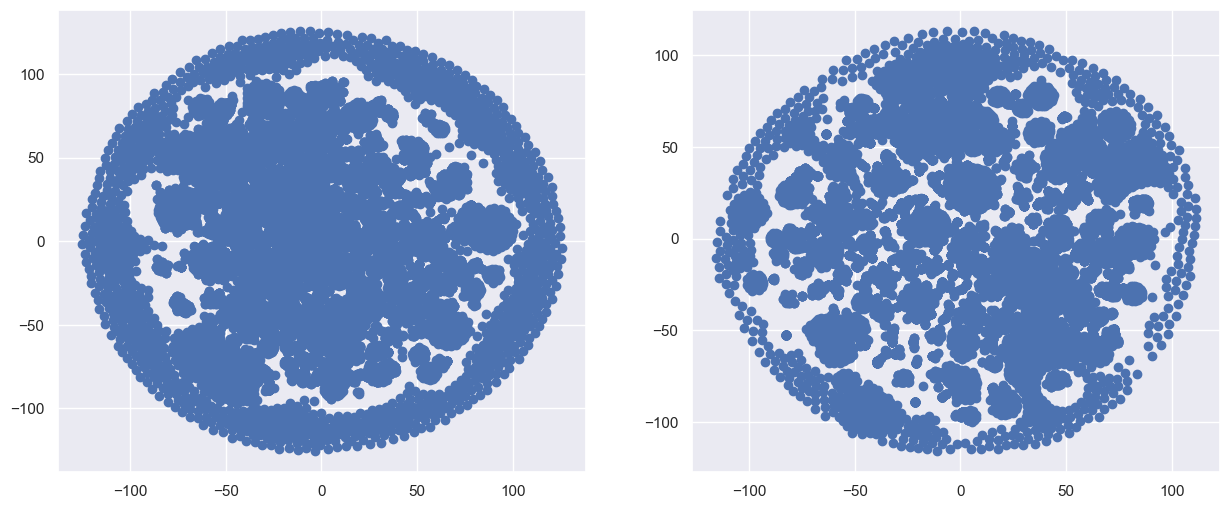

In [62]:
fig = plt.figure(figsize=(15,6))
    
ax = fig.add_subplot(121)
scatter = ax.scatter(y_pred_tsne[:,0],y_pred_tsne[:,1])

    
ax = fig.add_subplot(122)
scatter = ax.scatter(y_true_tsne[:,0],y_true_tsne[:,1])


## <a name="C3.2">3.2 Approche avec Word2Vec</a>

In [135]:
corpus = df.Body.tolist()

In [136]:
document = [" ".join(doc) for doc in corpus]
print (document[0])

loosing page left focus href working click next go open html class_name really button job rel switch application hung break throwing element right post bot apply www iframe noreferrer tag_name try pane indeed nofollow css_selector xpath nothing find used finding


In [137]:
# Use of a pretrained model with 200 dim 
from gensim.models import keyedvectors
trained = keyedvectors.load_word2vec_format("data/source/word2vec model SO_vectors_200.bin", binary=True)

In [138]:
trained.vectors.shape

(1787145, 200)

In [139]:
words=['virus','java','mysql']
for w in words:
    try:
        print(trained.most_similar(w))
    except KeyError as e:
            print(e)    

[('malware', 0.8455426692962646), ('viruses', 0.8440008759498596), ('antivirus', 0.8379445672035217), ('anti-virus', 0.8235737085342407), ('spyware', 0.7659316062927246), ('mcafee', 0.7542044520378113), ('malwarebytes', 0.7523449063301086), ('avast', 0.746547281742096), ('avira', 0.7376062870025635), ('anti-malware', 0.7363341450691223)]
[('jave', 0.7305739521980286), ('j2se', 0.6334486603736877), ('javase', 0.6294388771057129), ('scala', 0.6201649308204651), ('non-java', 0.61116623878479), ('javas', 0.6073753237724304), ('-java', 0.5853539705276489), ('jav', 0.5707030296325684), ('jdk', 0.5517216920852661), ('java5', 0.5513848662376404)]
[('postgresql', 0.799736499786377), ('postgres', 0.7909045219421387), ('mssql', 0.7834540605545044), ('mariadb', 0.7827133536338806), ('msql', 0.776264488697052), ('postgressql', 0.7286335229873657), ('mysql/mariadb', 0.7264211773872375), ('postresql', 0.7253730297088623), ('postgre', 0.7069053053855896), ('pgsql', 0.7036818861961365)]


In [140]:
print (trained.most_similar(positive=["king","woman"], negative=["man"]))

[('kings', 0.6783443093299866), ('princess', 0.6479538679122925), ('wolf', 0.6421284079551697), ('vampire', 0.6295422911643982), ('farmer', 0.6278953552246094), ('wolves', 0.624491810798645), ('deer', 0.6239059567451477), ('carpenter', 0.6189670562744141), ('knight', 0.6180094480514526), ('queen', 0.6177156567573547)]


In [141]:
def my_doc_2_vec(doc, trained):
    p = trained.vectors.shape[1]
    vec = np.zeros(p)
    nb = 0
    for tk in doc:
        try:
            values = trained[tk]
            vec = vec + values
            nb = nb + 1.0
        except:
            pass
    if (nb > 0.0):
        vec = vec/nb
    return vec

In [142]:
# traiter les documents du corpus
docsVec = list()
# Pour chaque document du corpus trouvé
for doc in corpus:
    # calcul de son vecteur
    vec = my_doc_2_vec(doc, trained)
    # ajouter dans la liste
    docsVec.append(vec)
# transformer en matrice numpy
matVec = np.array(docsVec)
print (matVec.shape)

(78451, 200)


In [143]:
# Transformer en DataFrame
dfv = pd.DataFrame(matVec, columns=["v"+str(i+1) for i in range(matVec.shape[1])])
dfv.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v191,v192,v193,v194,v195,v196,v197,v198,v199,v200
0,0.225985,0.881971,-0.044636,0.787802,-0.860534,0.108305,0.368539,0.034961,-0.510676,0.236565,...,0.423302,-0.461795,0.258953,-0.315691,0.622488,-1.080982,0.117904,0.256776,0.743751,0.497983
1,0.715605,1.008944,-1.080968,2.234846,-0.649524,0.213862,1.278794,-0.038473,0.084156,0.290828,...,0.476759,-0.832517,-1.607924,0.365063,-0.336973,-1.063603,-1.814247,0.619046,1.847413,-0.508820
2,-0.296413,0.717864,-0.346805,0.892468,-0.787986,0.063238,0.891530,-0.065129,-0.188734,-0.328888,...,-0.204109,-0.769139,-0.136225,-0.279922,0.420871,-0.660385,-1.080945,0.422155,1.064166,0.536978
3,1.347053,0.693123,-0.286017,1.017475,-0.549461,0.715567,1.069328,-0.201058,-0.298329,0.008226,...,-0.008187,-0.307075,-0.018589,0.430729,-0.932747,-1.391281,-0.254710,0.208658,0.269154,-0.547832
4,-0.059497,1.141351,0.118205,0.557467,-0.488644,-0.052398,1.051559,-0.003222,0.144809,-0.144088,...,0.091552,-0.230135,-0.108752,0.203241,0.547110,-0.882817,-0.354423,-0.189246,0.342619,-0.830493


In [144]:
corpus_tags = df.Tags.tolist()
docTag = [" ".join(doc) for doc in corpus_tags]
print (docTag[0])

html webdriver selenium python


In [145]:
dfv.shape

(78451, 200)

In [146]:
from sklearn.preprocessing import MultiLabelBinarizer
y = df["Tags"]
mlb = MultiLabelBinarizer()
mlb.fit(y)
y_mlb = mlb.transform(y)

In [147]:
df_res = train_clf("Word2Vec", OneVsRestClassifier(LinearSVC(dual=False, max_iter=10000)),df_res, dfv, y_mlb )

In [148]:
df_res

,Nom,Modele,Durée,Accuracy,Precision,Recall,F1_score,Jaccard spl,HammingLoss
0,LDA_LR,OneVsRestClassifier(estimator=LinearSVC(dual=F...,22.15,0.0,0.01,0.01,0.01,0.01,NaN
1,Dummy,OneVsRestClassifier(estimator=DummyClassifier(...,0.73,0.0,0.0,0.0,0.0,0.0,NaN
2,NaiveBayes,OneVsRestClassifier(estimator=MultinomialNB()),3.44,0.03,0.07,0.05,0.05,0.05,NaN
3,LogReg,OneVsRestClassifier(estimator=LogisticRegressi...,211.0,0.2,0.49,0.38,0.41,0.35,NaN
4,LinearSVC,OneVsRestClassifier(estimator=LinearSVC(dual=F...,239.04,0.15,0.37,0.28,0.3,0.26,NaN


## <a name="C3.3">3.3 Approche avec Doc2Vec</a>

In [25]:
#df.Post = df.Title + df.Body + df.Tags
#corpus = df.Post.tolist()
corpus = df.Body.tolist()

document = [" ".join(doc) for doc in corpus]
print (document[0])

loosing page left focus href working click next go open html class_name really button job rel switch application hung break throwing element right post bot apply www iframe noreferrer tag_name try pane indeed nofollow css_selector xpath nothing find used finding


In [26]:
# Vectorisation
from gensim.models import Word2Vec
modele = Word2Vec(corpus, vector_size=100, window=5, workers=4)

In [27]:
words = modele.wv

In [28]:
# affichage des termes et leur index
words.key_to_index

{'using': 0,
 'href': 1,
 'like': 2,
 'get': 3,
 'tried': 4,
 'rel': 5,
 'noreferrer': 6,
 'nofollow': 7,
 'trying': 8,
 'file': 9,
 'data': 10,
 'class': 11,
 'stack': 12,
 'way': 13,
 'imgur': 14,
 'problem': 15,
 'following': 16,
 'png': 17,
 'function': 18,
 'image': 19,
 'ha': 20,
 'src': 21,
 'example': 22,
 'know': 23,
 'new': 24,
 'wa': 25,
 'run': 26,
 'doe': 27,
 'img': 28,
 'make': 29,
 'alt': 30,
 'however': 31,
 'time': 32,
 'strong': 33,
 'pre': 34,
 'working': 35,
 'lang': 36,
 'override': 37,
 'user': 38,
 'app': 39,
 'prettyprint': 40,
 'see': 41,
 'first': 42,
 'find': 43,
 'enter': 44,
 'try': 45,
 'description': 46,
 'return': 47,
 'set': 48,
 'add': 49,
 'name': 50,
 'change': 51,
 'result': 52,
 'j': 53,
 'type': 54,
 'something': 55,
 'lt': 56,
 'getting': 57,
 'question': 58,
 'project': 59,
 'used': 60,
 'method': 61,
 'look': 62,
 'thanks': 63,
 'output': 64,
 'two': 65,
 'able': 66,
 'show': 67,
 'html': 68,
 'please': 69,
 'list': 70,
 'table': 71,
 'without

In [29]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_docs = [TaggedDocument(words=corpus[i], tags=["d"+str(i)]) for i in range(len(corpus))]

# 1er doc en exemple
print (tagged_docs[1])

TaggedDocument(['policy', 'following', 'set', 'rest', 'instance', 'get', 'access', 'nifi', 'trying', 'call', 'function', 'api', 'using', 'python'], ['d1'])


In [30]:
modeleDoc = Doc2Vec(vector_size=100, window=5)

# construction du dictionnaire
modeleDoc.build_vocab(tagged_docs)

In [31]:
# coordonnées des termes
pd.DataFrame(modeleDoc.wv.vectors, columns=["v"+str(i+1) for i in range(0,100)], index=modeleDoc.wv.key_to_index.keys())


,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100
using,-0.000536,0.000236,0.005103,0.009009,-0.009303,-0.007117,0.006459,0.008973,-0.005015,-0.003763,...,0.001631,0.000190,0.003474,0.000218,0.009619,0.005061,-0.008917,-0.007042,0.000901,0.006393
href,-0.008620,0.003666,0.005190,0.005742,0.007467,-0.006168,0.001106,0.006047,-0.002840,-0.006174,...,0.001088,-0.001576,0.002197,-0.007882,-0.002717,0.002663,0.005347,-0.002392,-0.009510,0.004506
like,0.000095,0.003077,-0.006813,-0.001375,0.007669,0.007346,-0.003673,0.002643,-0.008317,0.006205,...,-0.004509,0.005702,0.009180,-0.004100,0.007965,0.005375,0.005879,0.000513,0.008213,-0.007019
get,-0.008243,0.009299,-0.000198,-0.001967,0.004604,-0.004095,0.002743,0.006940,0.006065,-0.007511,...,-0.007426,-0.001064,-0.000795,-0.002563,0.009683,-0.000459,0.005874,-0.007448,-0.002506,-0.005550
tried,-0.007139,0.001241,-0.007177,-0.002245,0.003719,0.005833,0.001198,0.002103,-0.004110,0.007225,...,0.003137,-0.004713,0.005281,-0.004233,0.002642,-0.008046,0.006210,0.004819,0.000787,0.003013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
miller,0.007583,-0.007279,0.001942,0.008535,0.001957,-0.000957,0.006685,-0.009937,-0.008503,-0.001349,...,0.002177,0.000364,-0.007162,-0.000300,-0.009949,-0.006803,-0.002823,0.003657,-0.002536,-0.007875
stevens,0.006857,0.007403,0.006775,-0.001874,-0.003274,-0.007120,-0.006856,-0.005996,-0.000039,0.008693,...,0.005177,0.001244,0.002226,0.008510,-0.003298,0.008188,-0.007495,0.000840,0.003030,-0.002799
operationid,0.003779,-0.004525,-0.009515,0.007030,-0.007778,-0.003467,0.008607,0.008456,0.009493,0.006905,...,-0.002764,-0.009652,-0.009615,0.007296,-0.002824,0.005436,-0.006671,-0.001353,0.001740,-0.008652
setstring,0.003805,0.004735,0.000311,0.007329,-0.000012,0.004513,-0.002399,0.000798,0.007623,0.008039,...,0.003852,0.002676,-0.006610,-0.007650,-0.005306,0.000050,-0.007307,0.002969,0.003884,-0.006588


In [32]:
modeleDoc.train(tagged_docs, total_examples=modeleDoc.corpus_count,epochs=100)
print(modeleDoc.dv)

In [33]:
dfDoc2Vec = pd.DataFrame(modeleDoc.dv.vectors, columns=["v"+str(i+1) for i in range(0,100)])
print(dfDoc2Vec)

             v1        v2        v3        v4        v5        v6        v7  \
0      1.637155  0.678183 -0.442448  0.170181  0.189871 -0.804495 -0.992421   
1     -1.307424  1.832951  1.262720 -0.909567 -1.022162 -1.100397 -0.488933   
2     -0.532824 -0.975078 -1.458885 -1.051670 -1.105213 -1.176535  0.653446   
3      1.241800  0.207609  0.438600 -0.922193 -0.389435 -1.846472  1.058889   
4     -0.292948  0.532919 -0.266838 -3.026647 -1.001085 -0.039477 -0.615604   
...         ...       ...       ...       ...       ...       ...       ...   
78446 -1.601568  1.304801 -0.004218  0.034293 -0.747191 -0.254000  0.994477   
78447 -1.697262 -1.801825 -0.520506  0.642861  1.003724 -1.237482  1.212846   
78448 -1.037841  1.766057 -0.946969  0.992953 -0.769743  1.251575  1.613278   
78449 -0.711623 -0.178817  0.184124  0.093304 -0.019824  0.643962  0.893458   
78450 -1.325655  0.786032  0.729045  0.081895  0.856254  0.709266 -1.021276   

             v8        v9       v10  ...       v91 

In [34]:
from sklearn.preprocessing import MultiLabelBinarizer
y = df["Tags"]
mlb = MultiLabelBinarizer()
mlb.fit(y)
y_mlb = mlb.transform(y)

In [35]:
y_mlb.shape

(78451, 100)

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
X_train, X_test, y_train, y_test = train_test_split(dfDoc2Vec, y_mlb, test_size=0.3, random_state=42)
clf = OneVsRestClassifier(LinearSVC(dual=False, max_iter=10000)).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [39]:
df_res = train_clf("Doc2Vec", OneVsRestClassifier(LinearSVC(dual=False, max_iter=10000)),df_res, dfDoc2Vec, y_mlb )
df_res

,Nom,Modele,Durée,Accuracy,Precision,Recall,F1_score,Jaccard spl
0,Doc2Vec,OneVsRestClassifier(estimator=LinearSVC(dual=F...,73.78,0.06,0.16,0.11,0.12,0.1


In [40]:
y_pred_inversed = mlb.inverse_transform(y_pred)
y_test_inversed = mlb.inverse_transform(y_test)

print("Predicted: ", y_pred_inversed[0:10])
print("True     : ", y_test_inversed[0:10])

Predicted:  [(), (), (), (), (), (), (), (), (), ()]
True     :  [('javascript', 'typescript'), ('c', 'net'), ('function', 'javascript', 'reactjs'), ('python', 'string'), ('php',), ('authentication', 'web'), ('javascript', 'reactjs'), ('python',), ('j',), ('angular', 'django', 'framework', 'rest')]


In [41]:
from sklearn import metrics
print (metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.04      0.07       606
           1       0.66      0.22      0.33       981
           2       0.00      0.00      0.00       462
           3       0.00      0.00      0.00       396
           4       0.00      0.00      0.00       799
           5       0.00      0.00      0.00       171
           6       0.00      0.00      0.00       339
           7       0.00      0.00      0.00       386
           8       0.00      0.00      0.00       173
           9       0.57      0.01      0.03       301
          10       0.89      0.03      0.06       546
          11       0.00      0.00      0.00       137
          12       0.68      0.18      0.29       438
          13       0.67      0.13      0.21      2138
          14       0.00      0.00      0.00       150
          15       0.00      0.00      0.00       490
          16       0.00      0.00      0.00       351
          17       0.00    

In [42]:
y_pred = clf.predict(X_test)
jaccard_score(y_test, y_pred, average='samples')

0.10231802952316209

In [43]:
y_pred_inversed = mlb.inverse_transform(y_pred)
y_test_inversed = mlb.inverse_transform(y_test)

print("Predicted: ", y_pred_inversed[0:5])
print("True     : ", y_test_inversed[0:5])

Predicted:  [(), (), (), (), ()]
True     :  [('javascript', 'typescript'), ('c', 'net'), ('function', 'javascript', 'reactjs'), ('python', 'string'), ('php',)]


## <a name="C3.4">3.4 Approche avec Glove</a>

In [ ]:
# subdivision apprentissage - tests de données

In [67]:
tag = [" ".join(doc) for doc in df.Tags]

In [68]:
df["tag"]=""
for i in range(len(df)):
    df.iloc[i,3] = df.iloc[i,2][0]
df.tag

0         
1         
2         
3         
4         
        ..
44897     
44898     
44899     
44900     
44901     
Name: tag, Length: 44902, dtype: object

In [69]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(df.tag)
y

array([0, 0, 0, ..., 0, 0, 0])

In [173]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.Body, y, stratify=y, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)

(54915,)
(23536,)


In [174]:
dfTrain

58833    [unhandled, capacitorjs, trackjs, saw, phone, ...
74924    [ddd, satisfy, postgres, table, bbb, available...
33563    [image, crunched, src, authenticated, add, ham...
13399    [file_name, replace, char, tab, wrote, single,...
70467    [part, give, fail, question, class, day, metho...
                               ...                        
21243    [part, expect, fail, behind, get, href, reason...
45891    [src, add, get, us, basic, selected, imgur, to...
42613    [github, page, cm, currently, href, problem, l...
43567    [complete, webpack, get, compiling, j, dreadde...
68268    [notebook, share_link, format, image, question...
Name: Body, Length: 54915, dtype: object

In [175]:
import keras

In [176]:
from keras.preprocessing.text import Tokenizer
# num_words = None = sans limitation du nombre de termes à extraire
tk = Tokenizer(num_words=None)

# création du dictionnaire à partir des documents de l'ech d'apprentissage
tk.fit_on_texts(X_train)

# nombre de documents traités
print (tk.document_count)


54915


In [177]:
# taille du dictionnaire
dico_size = len(tk.word_counts)
print (dico_size)

93150


In [178]:
# liste des termes avec leur indice
print(list(tk.word_index.items())[:10])

[('using', 1), ('href', 2), ('like', 3), ('tried', 4), ('get', 5), ('rel', 6), ('noreferrer', 7), ('nofollow', 8), ('trying', 9), ('file', 10)]


In [179]:
# transformation des documents en séquence de tokens
seqTrain = tk.texts_to_sequences(X_train)
print (seqTrain[:3])

[[694, 57, 1195, 2490, 20, 95, 838, 22, 570, 59, 4339, 934, 2, 1353, 977, 416, 3682, 15, 390, 1102, 372, 30554, 303, 29, 514, 24, 48, 3754, 6, 321, 102, 49, 293, 13, 66, 404, 32, 648, 2142, 53, 60, 11, 39, 18, 45, 573, 1, 3475, 2476, 2276, 272, 291, 17, 7, 268, 269, 405, 113, 463, 8, 65, 1470, 1130, 4402, 148, 196, 21, 44, 30555, 25, 2374], [253, 16, 36, 114, 87, 47, 203, 1749, 100, 549, 182, 9, 2078, 192, 119, 42, 113, 1043, 34, 324, 3156, 1091], [20, 824, 22, 7888, 202, 5, 2, 2001, 15, 177, 304, 887, 29, 2239, 1750, 48, 1133, 120, 79, 1394, 6694, 6, 13, 2713, 1818, 60, 18, 529, 45, 1, 2623, 7, 46, 140, 14, 8, 13145, 461, 1570, 25, 184, 32]]


In [180]:
# Longueur max des documents
max_length = np.max(np.array([len(doc) for doc in X_train]))
print (max_length)

401


In [181]:
# transformer en pad_sequences pour manipuler une structure de taille fixe
marge = 5
from keras_preprocessing.sequence import pad_sequences
padTrain = pad_sequences(seqTrain, maxlen=max_length + marge, padding='post')

print (padTrain[:3,:])

[[ 694   57 1195 ...    0    0    0]
 [ 253   16   36 ...    0    0    0]
 [  20  824   22 ...    0    0    0]]


In [234]:
# structure dictionnaire pour stocker les couples termes/vecteurs
embeddings_index = {}
# ouvrir le fichier préentrainé de dim 50 en lecture
f = open("data/source/glove.42B.300d.txt", "r", encoding="utf-8")
# lire ligne par ligne et décomposer
for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs
# fermer le fichier
f.close()

In [235]:
# Vérification du nombre de termes
print("Found %s words vectors." %len(embeddings_index))

Found 1917494 words vectors.


In [231]:
# Coordonnées des 3 premiers termes
print(list(embeddings_index.items())[:3])

[('the', array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0

In [232]:
# coordonnées de 'good'
print(embeddings_index["good"])

[-0.030769   0.11993    0.53909   -0.43696   -0.73937   -0.15345
  0.081126  -0.38559   -0.68797   -0.41632   -0.13183   -0.24922
  0.441      0.085919   0.20871   -0.063582   0.062228  -0.051234
 -0.13398    1.1418     0.036526   0.49029   -0.24567   -0.412
  0.12349    0.41336   -0.48397   -0.54243   -0.27787   -0.26015
 -0.38485    0.78656    0.1023    -0.20712    0.40751    0.32026
 -0.51052    0.48362   -0.0099498 -0.38685    0.034975  -0.167
  0.4237    -0.54164   -0.30323   -0.36983    0.082836  -0.52538
 -0.064531  -1.398     -0.14873   -0.35327   -0.1118     1.0912
  0.095864  -2.8129     0.45238    0.46213    1.6012    -0.20837
 -0.27377    0.71197   -1.0754    -0.046974   0.67479   -0.065839
  0.75824    0.39405    0.15507   -0.64719    0.32796   -0.031748
  0.52899   -0.43886    0.67405    0.42136   -0.11981   -0.21777
 -0.29756   -0.1351     0.59898    0.46529   -0.58258   -0.02323
 -1.5442     0.01901   -0.015877   0.024499  -0.58017   -0.67659
 -0.040379  -0.44043    0.0

In [236]:
# Nombre de tokens = taille du dictionnaire + 1
num_tokens = dico_size +1

# dimension de représentation 
embedding_dim = 300

# nombre de termes trouvés et liste non trouvés
hit = 0
misses = []

# remplir la matrice vaec les coordonnées issues de la représentation pré entrainée
# initialisation à 0
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in tk.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if not(embedding_vector is None):
        embedding_matrix[i] = embedding_vector
        # compteur
        hit = hit + 1
    else:
        misses.append(word)

print('Termes du dico trouvés : ' + str(hit))
print ('Termes non trouvés : ' + str(len(misses)))


Termes du dico trouvés : 32143
Termes non trouvés : 61007


In [237]:
print (misses[:20])

['noreferrer', 'vscode', 'dockerfile', 'kubernetes', 'chatgpt', 'useeffect', 'nextjs', 'usestate', 'jupyter', 'tensorflow', 'codesandbox', 'dataframes', '__init__', 'googleapis', 'swiftui', 'blazor', 'queryselector', 'reactjs', 'pytorch', 'graphql']


In [238]:
# Librairies
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding

# construction de la couche initiale embeddings à partir de la représentation pré entrainée
embedding_layer = Embedding(
    input_dim=num_tokens,
    output_dim=embedding_dim,
    input_length=max_length + marge,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable = False)


In [239]:
# Construction du perceptron multicouche
pmc = Sequential()
pmc.add(embedding_layer)
pmc.add(Flatten())
pmc.add(Dense(units=1, activation='sigmoid'))

# structure du réseau
print (pmc.summary())


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 406, 300)          27945300  
                                                                 
 flatten_4 (Flatten)         (None, 121800)            0         
                                                                 
 dense_4 (Dense)             (None, 1)                 121801    
                                                                 
Total params: 28,067,101
Trainable params: 121,801
Non-trainable params: 27,945,300
_________________________________________________________________
None


In [240]:
# paramétrage de l'algorithme d'apprentissage
pmc.compile(loss="binary_crossentropy", optimizer="adam",metrics=['accuracy'])

#Lancement une partie du train est réservée pour la validation
history = pmc.fit(padTrain, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
1373/1373 [==============================] - 22s 15ms/step - loss: -20912.5020 - accuracy: 0.0175 - val_loss: -42251.4805 - val_accuracy: 0.0148
Epoch 2/10
1373/1373 [==============================] - 21s 15ms/step - loss: -63130.7773 - accuracy: 0.0175 - val_loss: -84718.9375 - val_accuracy: 0.0148
Epoch 3/10
1373/1373 [==============================] - 21s 15ms/step - loss: -105372.1328 - accuracy: 0.0175 - val_loss: -127159.8281 - val_accuracy: 0.0148
Epoch 4/10
1373/1373 [==============================] - 21s 15ms/step - loss: -147547.0625 - accuracy: 0.0175 - val_loss: -169519.1875 - val_accuracy: 0.0148
Epoch 5/10
1373/1373 [==============================] - 21s 15ms/step - loss: -189750.3906 - accuracy: 0.0175 - val_loss: -211963.8281 - val_accuracy: 0.0148
Epoch 6/10
1373/1373 [==============================] - 21s 16ms/step - loss: -231995.2344 - accuracy: 0.0175 - val_loss: -254401.0938 - val_accuracy: 0.0148
Epoch 7/10
1373/1373 [==============================] - 

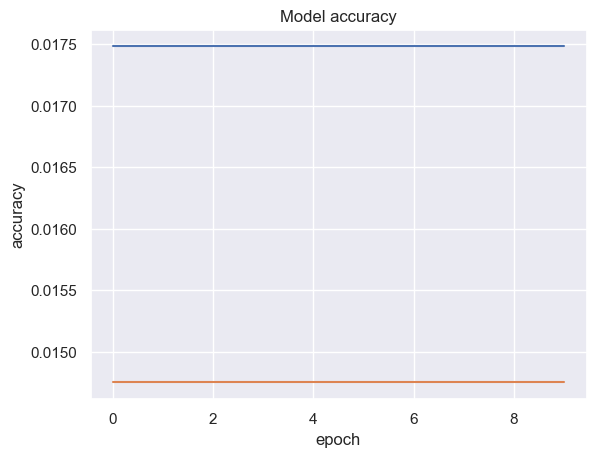

In [241]:
# fonction pour evolution de l'accuracy
def graphique(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

graphique(history)

In [195]:
history.history

{'loss': [-9070.10546875,
  -27310.451171875,
  -45539.36328125,
  -63772.1171875,
  -82002.765625,
  -100230.5234375,
  -118458.75,
  -136702.734375,
  -154914.25,
  -173139.90625],
 'accuracy': [0.01748156175017357,
  0.01748156175017357,
  0.01748156175017357,
  0.01748156175017357,
  0.01748156175017357,
  0.01748156175017357,
  0.01748156175017357,
  0.01748156175017357,
  0.01748156175017357,
  0.01748156175017357],
 'val_loss': [-18234.28515625,
  -36548.46484375,
  -54809.9765625,
  -73088.421875,
  -91363.875,
  -109618.7890625,
  -127915.421875,
  -146183.0625,
  -164450.0,
  -182715.390625],
 'val_accuracy': [0.014750068075954914,
  0.014750068075954914,
  0.014750068075954914,
  0.014750068075954914,
  0.014750068075954914,
  0.014750068075954914,
  0.014750068075954914,
  0.014750068075954914,
  0.014750068075954914,
  0.014750068075954914]}

In [196]:
# coodonnées des termes issus du réseau de neurones
terms_coord = pmc.get_weights()[0]
print (terms_coord)

[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.52404  -0.39838   0.70412  ...  0.14325   0.020076 -0.35484 ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 ...
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]


In [198]:
# coordonnées de "good" dans le réseau
coord_good = terms_coord[tk.word_index['good'],:]
print (coord_good)

[-3.5586e-01  5.2130e-01 -6.1070e-01 -3.0131e-01  9.4862e-01 -3.1539e-01
 -5.9831e-01  1.2188e-01 -3.1943e-02  5.5695e-01 -1.0621e-01  6.3399e-01
 -4.7340e-01 -7.5895e-02  3.8247e-01  8.1569e-02  8.2214e-01  2.2220e-01
 -8.3764e-03 -7.6620e-01 -5.6253e-01  6.1759e-01  2.0292e-01 -4.8598e-02
  8.7815e-01 -1.6549e+00 -7.7418e-01  1.5435e-01  9.4823e-01 -3.9520e-01
  3.7302e+00  8.2855e-01 -1.4104e-01  1.6395e-02  2.1115e-01 -3.6085e-02
 -1.5587e-01  8.6583e-01  2.6309e-01 -7.1015e-01 -3.6770e-02  1.8282e-03
 -1.7704e-01  2.7032e-01  1.1026e-01  1.4133e-01 -5.7322e-02  2.7207e-01
  3.1305e-01  9.2771e-01]


In [242]:
# Préparation de l'échantillon de test
seqTest = tk.texts_to_sequences(X_test)
padTest = pad_sequences(seqTest, maxlen=max_length + marge, padding='post')

# 2 premiers posts de test
print(X_test[:3])

# représentation des séquences
print (padTest[:3,:])

25771    [capture, behaviour, false, method, whatever, ...
2320     [implemented, sort, implement, question, repla...
9596     [sufficiently, simplified, shiny, interface, w...
Name: Body, dtype: object
[[1195  991  137 ...    0    0    0]
 [ 615  544  271 ...    0    0    0]
 [7676 1158 2376 ...    0    0    0]]


In [243]:
# Evluation des performances en test
print(pmc.evaluate(padTest, y_test))

736/736 [==============================] - 6s 8ms/step - loss: -427218.8438 - accuracy: 0.0170
[-427218.84375, 0.0169527530670166]


In [244]:
# test nouveau post
my_post = ['pyhton', 'need', 'coding']
my_seq = tk.texts_to_sequences([my_post])
my_pad = pad_sequences(my_seq, maxlen=max_length + marge, padding='post')

print (my_pad)
print (pmc.predict(my_pad))


[[9402  907    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

In [246]:
#le.inverse_transform
x = pmc.predict(my_pad)[0]

1/1 [==============================] - 0s 20ms/step


## <a name="C3.5">3.5 Approche avec BERT</a>

In [1]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

2023-05-09 09:09:50.010517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/lib/python3.9/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [2]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.12.0
2.12.0
Num GPUs Available:  0
False


In [3]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [4]:
def delaye(sent):
    sent = " ".join([w for w in sent])
    return sent

In [10]:
df['Body_dl'] = df.Body.apply(delaye)

In [11]:
dfc = df.sample(5000)

In [12]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = dfc['Body_dl'].tolist()

loading configuration file config.json from cache at /Users/claude/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at /Users/claude/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b

In [13]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at /Users/claude/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/claude/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt

1/1 [==============================] - 1s 567ms/step


1/1 [==============================] - 1s 595ms/step
temps traitement :  501.0


In [14]:
from sklearn.preprocessing import MultiLabelBinarizer
y = dfc["Tags"]
mlb = MultiLabelBinarizer()
mlb.fit(y)
y_mlb = mlb.transform(y)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_bert, y_mlb,
                                                    test_size=0.3, random_state=42)

In [16]:
%%time
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

svm_clf = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

CPU times: user 1.39 s, sys: 448 ms, total: 1.84 s
Wall time: 32.3 s


In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,\
                            recall_score, f1_score, jaccard_score
print("Accuracy : ", accuracy_score(y_test, y_pred))
print("Precision : ", precision_score(y_test, y_pred, average='samples'))
print("Recall : ", recall_score(y_test, y_pred, average='samples')) 
print("F1 Score : ", f1_score(y_test, y_pred, average='samples'))
print("Jaccard :", jaccard_score(y_test, y_pred, average='samples'))

Accuracy :  0.06866666666666667
Precision :  0.22865714285714284
Recall :  0.19174285714285713
F1 Score :  0.19084083694083695
Jaccard : 0.1556468253968254


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## <a name="C3.6">3.6 Approche avec USE</a>

In [21]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [22]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.12.0
2.12.0
Num GPUs Available:  0
False


In [19]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [23]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [25]:
batch_size = 10
sentences = dfc['Body_dl'].tolist()

In [26]:
features_USE = feature_USE_fct(sentences, batch_size)

2023-05-09 09:30:36.877496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


In [27]:
features_USE

array([[ 0.03587618, -0.04739883,  0.01024617, ...,  0.08034296,
         0.03169267,  0.01666827],
       [-0.06908611, -0.07706169,  0.01453111, ...,  0.07684138,
        -0.04533145, -0.02334308],
       [-0.0376628 , -0.07300697, -0.03367553, ...,  0.07321359,
        -0.04829616, -0.03615903],
       ...,
       [-0.05411969, -0.07232241, -0.02099957, ...,  0.07771657,
        -0.04693438, -0.06755118],
       [-0.03548364, -0.07085324,  0.05043969, ...,  0.07132116,
        -0.05984877, -0.02841382],
       [-0.05402068, -0.08197869,  0.05817263, ...,  0.04040778,
        -0.06572682, -0.07382154]], dtype=float32)

In [28]:
from sklearn.preprocessing import MultiLabelBinarizer
y = dfc["Tags"]
mlb = MultiLabelBinarizer()
mlb.fit(y)
y_mlb = mlb.transform(y)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_bert, y_mlb,
                                                    test_size=0.3, random_state=42)

In [30]:
%%time
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

svm_clf = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

CPU times: user 1.35 s, sys: 411 ms, total: 1.76 s
Wall time: 37.9 s


In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,\
                            recall_score, f1_score, jaccard_score
print("Accuracy : ", accuracy_score(y_test, y_pred))
print("Precision : ", precision_score(y_test, y_pred, average='samples'))
print("Recall : ", recall_score(y_test, y_pred, average='samples')) 
print("F1 Score : ", f1_score(y_test, y_pred, average='samples'))
print("Jaccard :", jaccard_score(y_test, y_pred, average='samples'))

Accuracy :  0.06933333333333333
Precision :  0.22965714285714284
Recall :  0.1919095238095238
F1 Score :  0.19132972582972582
Jaccard : 0.1561468253968254


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
y_pred_inversed = mlb.inverse_transform(y_pred)
y_test_inversed = mlb.inverse_transform(y_test)
print("Predicted: " + str(y_pred_inversed[0:5]))
print("True     : " + str(y_test_inversed[0:5]))

Predicted: [(), ('r',), ('c', 'dart', 'flutter'), (), ('swiftui',)]
True     : [('java',), ('r',), ('powershell',), ('python',), ('swift',)]
